In [1]:
import torch
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset
import string

In [2]:
import keras
import numpy as np
import tensorflow as tf
import sys
sys.path.append('../')
from utils.lib import *

Using TensorFlow backend.


In [3]:
import re
import os
import cv2
import html
import string
import numpy as np
import numba as nb


def adjust_to_see(img):

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))

    return img


def normalization(img):
    
    m, s = cv2.meanStdDev(img)
    img = img - m[0][0]
    img = img / s[0][0] if s[0][0] > 0 else img
    return img



def preprocess(img, input_size):

    def imread(path):
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

        if len(img.shape) == 3:
            if img.shape[2] == 4:
                trans_mask = img[:, :, 3] == 0
                img[trans_mask] = [255, 255, 255, 255]

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        return img

    if isinstance(img, str):
        img = imread(img)

    if isinstance(img, tuple):
        image, boundbox = img
        img = imread(image)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))
    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    img = illumination_compensation(img)
    img = remove_cursive_style(img)
    img = cv2.resize(img, new_size)

    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)

    return img




RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)


def text_standardize(text):

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: f" {c} " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text

import string
import unicodedata
import editdistance
import numpy as np


def hcr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):
        pd, gt = pd.lower(), gt.lower()

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd), list(gt)
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.split(), gt.split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    metrics = [cer, wer, ser]
    metrics = np.mean(metrics, axis=1)

    return metrics

## Data Loading

In [4]:

data, label_file = load_data('',['../src/Method 2_dataset/thumbnail_augment/'])

data = np.expand_dims(data,axis=0)

data = data.reshape(15297,30,375,1)

data = data/255.

label = read_final_label('../src/Method 2_dataset/final_augment_handwritten.txt')

In [5]:
data, label = shuffle(data,label, random_state=42)

label = [i.replace('||',' ') for i in label]
label = [i.replace('|',' ') for i in label]
label = [i[1:] if i[0]==' ' else i for i in label]
label = [i[:-1] if i[-1]==' ' else i for i in label]
label = [i.replace('  ',' ') for i in label]
label = [i.replace('\n','') for i in label]

chars = string.printable[:95]

encoded_label = [encode_string(i,chars) for i in label]

maxv = 0
for i in encoded_label:
    if len(i) > maxv:
        maxv = len(i)


pad_label = copy.deepcopy(encoded_label)
for i in range(len(pad_label)):
    if len(pad_label[i])<maxv:
        diff = maxv - len(pad_label[i])
        for j in range(diff):
            pad_label[i].append(chars.find(' '))
       

In [6]:
valid_padded_txt = list()
train_padded_txt = list()
test_padded_txt = list()
# lists for training dataset
train_img = []
train_txt = []
train_input_length = []
train_label_length = []
train_orig_txt = []

#lists for test dataset
test_img = []
test_txt = []
test_input_length = []
test_label_length = []
test_orig_txt = []

#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
for i in range(len(data)):
    if i < 1472:
        valid_orig_txt.append(label[i])   
        valid_label_length.append(len(label[i]))
        valid_input_length.append(62)
        valid_img.append(data[i])
        valid_txt.append(encoded_label[i])
        valid_padded_txt.append(pad_label[i])
    
    elif i >= 1472 and i < 2944:
        test_orig_txt.append(label[i])   
        test_label_length.append(len(label[i]))
        test_input_length.append(62)
        test_img.append(data[i])
        test_txt.append(encoded_label[i])
        test_padded_txt.append(pad_label[i])
        
    elif i >=2944 and i<15296:
        train_orig_txt.append(label[i])   
        train_label_length.append(len(label[i]))
        train_input_length.append(62)
        train_img.append(data[i])
        train_txt.append(encoded_label[i])
        train_padded_txt.append(pad_label[i])

## Model

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=64):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [8]:
class HCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()

        self.backbone = resnet101()
        del self.backbone.fc
        
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)


        self.vocab = nn.Linear(hidden_dim,vocab_len)

        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = PositionalEncoding(hidden_dim, .2)


        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.trg_mask = None
  
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x


    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, trg):
        x = self.get_feature(inputs)

        h = self.conv(x)

        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(trg.shape[1]).to(trg.device)

        trg_pad_mask = self.make_len_mask(trg)

        trg = self.decoder(trg)
        trg = self.query_pos(trg)
        
        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), trg.permute(1,0,2), tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):
    
    return HCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

In [9]:
class Tokenizer():

    def __init__(self, chars, max_text_length=64):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):

        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")

In [10]:
import torchvision.transforms as T

input_size = (30, 375, 3)
max_text_length = 64
charset_base = string.printable[:95]
transform = T.Compose([
    T.ToTensor()])
tokenizer = Tokenizer(charset_base,64)


In [11]:
device = torch.device("cpu")
model = make_model(vocab_len=tokenizer.vocab_size,hidden_dim=1024,nheads=8,
                 num_encoder_layers=8, num_decoder_layers=8)
_=model.to(device)

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import PIL
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.tokenizer = Tokenizer(string.printable[:95], 64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        _x = self.X[index]
        img = np.repeat(_x[..., np.newaxis],3, -1)    
        img = normalization(img)

        img = transform(img)
        
        _y = self.Y[index]

        y_train = self.tokenizer.encode(_y) 

        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)
        
        return img, gt

In [15]:
strain_img = list()
svalid_img = list()
stest_img = list()

for item in train_img:
    strain_img.append(np.asarray(item.reshape(30,375)))
    
for item in test_img:
    stest_img.append(np.asarray(item.reshape(30,375)))

for item in valid_img:
    svalid_img.append(np.asarray(item.reshape(30,375)))

In [16]:

training_set = Dataset(train_img, train_txt)
valid_set = Dataset(valid_img, valid_txt)

train_loader = DataLoader(Dataset(strain_img, train_orig_txt), batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(Dataset(svalid_img, valid_orig_txt), batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(Dataset(stest_img, test_orig_txt), batch_size=1, shuffle=False, num_workers=0)


In [117]:
i=0
for batch, (imgs, labels_y,) in enumerate(valid_loader):

    print(imgs[0].shape)
    a = imgs

torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])
torch.Size([3, 30, 375])


In [118]:
a.shape

torch.Size([64, 3, 30, 375])

In [16]:
imgs[0].shape

torch.Size([3, 30, 375])

In [17]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx=0, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [18]:
criterion = LabelSmoothing(size=tokenizer.vocab_size, padding_idx=0, smoothing=0.1)
criterion.to(device)
lr = .0001 
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

In [19]:
def train(model, criterion, optimiser, scheduler,dataloader):

    model.train()
    total_loss = 0
    for batch, (imgs, labels_y,) in enumerate(dataloader):
        imgs = imgs.to(device)
        labels_y = labels_y.to(device)
        optimizer.zero_grad()
        output = model(imgs.float(),labels_y.long()[:,:-1])

        norm = (labels_y != 0).sum()
        loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()
        total_loss += loss.item() * norm
    return [total_loss,total_loss]

def evaluate(model, criterion, dataloader,):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch, (imgs, labels_y,) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels_y = labels_y.to(device)

            output = model(imgs.float(),labels_y.long()[:,:-1])

            norm = (labels_y != 0).sum()
            loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm

            epoch_loss += loss.item() * norm

    return epoch_loss / len(dataloader)

In [20]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs_pytorch_rec/modelI/')

model.load_state_dict(torch.load('runs_pytorch_rec/modelI/torch_model.hdf5'))

In [21]:
import time
import numpy as np

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_time, elapsed_mins, elapsed_secs

best_valid_loss = np.inf
c = 0

for epoch in range(0,100):
 
    print(f'Epoch: {epoch+1:02}','learning rate{}'.format(scheduler.get_last_lr()))
    
    start_time = time.time()

    train_loss,outputs = train(model, criterion, optimizer, scheduler, train_loader)
    valid_loss = evaluate(model, criterion, valid_loader)

    epoch_time2, epoch_mins, epoch_secs = epoch_time(start_time, time.time())
 
    c+=1
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'runs_pytorch_rec/modelI/torch_model.hdf5')
        c=0
 
    if c>4:
        scheduler.step()
        c=0
    
    print(f'Time: {epoch_mins}m {epoch_secs}s') 
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/valid", valid_loss, epoch)
writer.flush()

Epoch: 01 learning rate[0.0001]
Time: 127m 5s
Train Loss: 327113.094
Val   Loss: 1777.603
Epoch: 02 learning rate[0.0001]
Time: 128m 2s
Train Loss: 324822.438
Val   Loss: 1775.039
Epoch: 03 learning rate[0.0001]
Time: 162m 18s
Train Loss: 324553.875
Val   Loss: 1773.343
Epoch: 04 learning rate[0.0001]
Time: 161m 7s
Train Loss: 324325.469
Val   Loss: 1772.192
Epoch: 05 learning rate[0.0001]
Time: 169m 26s
Train Loss: 324123.812
Val   Loss: 1771.678
Epoch: 06 learning rate[0.0001]
Time: 154m 11s
Train Loss: 321656.625
Val   Loss: 1826.218
Epoch: 07 learning rate[0.0001]
Time: 129m 58s
Train Loss: 317014.562
Val   Loss: 1943.879
Epoch: 08 learning rate[0.0001]
Time: 128m 53s
Train Loss: 313350.906
Val   Loss: 2260.715
Epoch: 09 learning rate[0.0001]
Time: 132m 35s
Train Loss: 312263.000
Val   Loss: 2342.781
Epoch: 10 learning rate[0.0001]
Time: 128m 43s
Train Loss: 311599.875
Val   Loss: 2502.452
Epoch: 11 learning rate[9.5e-05]
Time: 157m 7s
Train Loss: 311156.938
Val   Loss: 2492.644
Ep

KeyboardInterrupt: 

## Testing

In [20]:
def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    with torch.no_grad():
        for batch in test_loader:
            src, trg = batch
            imgs.append(src.flatten(0,1))
            src, trg = src.cpu(), trg.cpu()            
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                mask = model.generate_square_subsequent_mask(i+1).to('cpu')
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=mask))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(trg.flatten(0,1)))
    return predicts, gt, imgs

In [125]:
for batch in test_loader:
    src, trg = batch

In [137]:
img = src.flatten(0,1)
src, trg = src.cpu(), trg.cpu() 

In [138]:
src.shape

torch.Size([1, 3, 30, 375])

In [127]:
memory = model.get_feature(src.float())

In [26]:
memory.shape

torch.Size([1, 2048, 1, 12])

In [52]:
a = memory.cpu().detach().numpy()

In [53]:
a.shape

(1, 2048, 1, 12)

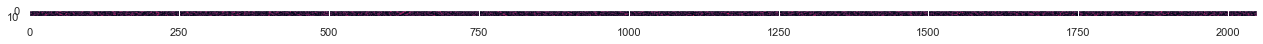

In [63]:
plt.imshow(a.reshape(12,2048))

In [58]:
a = a.reshape(2048,12)

In [64]:
a = a[:512]

In [65]:
a.shape

(512, 12)

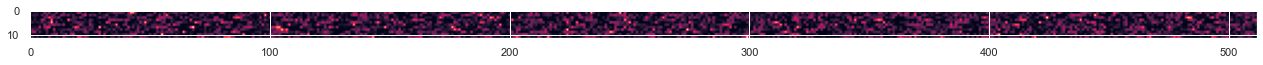

In [69]:
plt.imshow(a.reshape(12,512))
plt.savefig('ab')

In [82]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms

In [102]:
model_children = list(model.backbone.children())
model_weights = [] # we will save the conv layer weights in this list
conv_layers = []

In [103]:
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 100


In [104]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [176]:
b = model_weights[0]

In [177]:
b.shape

torch.Size([64, 3, 7, 7])

torch.Size([3, 7, 7])


RuntimeError: only one dimension can be inferred

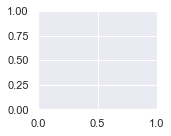

In [183]:
plt.figure(figsize=(20, 17))
for i, filters in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filters[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('c_outputs/filter.png')
plt.show()

In [140]:
results = [conv_layers[0](src.float())]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [188]:
outputs[0][0,:,:,:].data.shape

torch.Size([64, 15, 188])

In [190]:
filters.shape

torch.Size([2, 24])

In [ ]:
for num_layer in range(0,5):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filters in enumerate(layer_viz):
        if i == 16: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(4, 4, i + 1)
        plt.imshow(filters)
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"c_outputs/layer_{num_layer}.png", dpi = 300)
    # plt.show()
    plt.close()

torch.Size([64, 15, 188])
Saving layer 0 feature maps...


In [78]:
plot_weights(model, 0, single_channel = False)

AttributeError: 'HCR' object has no attribute 'features'

In [23]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shape
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))

In [21]:
model.load_state_dict(torch.load('runs_pytorch_rec/modelI/torch_model.hdf5'))

<All keys matched successfully>

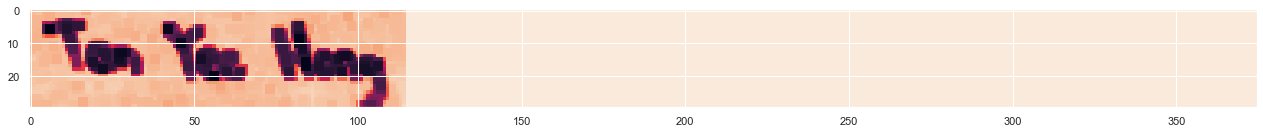

In [25]:
plt.imshow(test_img[9])

In [26]:
test_orig_txt[9]

'Tan Yee Hong'

In [27]:
predicts, gt, imgs = test(model, test_loader, max_text_length)


In [28]:
predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

imgss = list()
predictss = list()
for i, item in enumerate(imgs):
    print("=" * 20, "\n")
    imgss.append(item)
    plt.imshow(item.reshape(30,375,3))
    predictss.append(predicts[i])
    print("Ground truth:",gt[i])
    print("Prediction :", predicts[i], "\n")

In [ ]:
len(test_img)

In [ ]:
len(train_img)

In [29]:
evaluate = hcr_metrics(predicts=predicts,
                                  ground_truth=gt,)
 
print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))

Calculate Character Error Rate 1.0, Word Error Rate 1.0 and Sequence Error Rate 1.0


In [ ]:
bbb